## Setup

In [1]:
# For tips on running notebooks in Google Colab, see
# https://pytorch.org/tutorials/beginner/colab
%matplotlib inline

In [2]:
import numpy as np
import os

import torch
import torch.nn as nn
import torch.nn.functional as F

# for importing data
import torchvision
import torchvision.transforms as T
from torch.utils.data import DataLoader, Subset
from torch.optim import lr_scheduler

import matplotlib.pyplot as plt
from IPython import display
display.set_matplotlib_formats('png')

from tempfile import TemporaryDirectory
import time


C:\Users\oanld\AppData\Local\Temp\ipykernel_21208\688771723.py:16: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  display.set_matplotlib_formats('png')


## Load Data

In [3]:
if torch.cuda.is_available:
  print('Good to go!')
else:
  print('Please set GPU via Edit -> Notebook Settings.')

#use GPU if available
device = torch.device('cuda:0' if torch.cuda.is_available else 'cpu')

Good to go!


In [4]:
def load_data(train_dir, valid_dir, batchsize):
    transform = T.Compose([T.ToTensor(),
                        T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
                        ])

    trainset = torchvision.datasets.ImageFolder(root=train_dir, transform=transform)
    validset = torchvision.datasets.ImageFolder(root=valid_dir, transform=transform)


    train_loader = DataLoader(trainset, batch_size=batchsize, shuffle=True, drop_last=True)
    valid_loader = DataLoader(validset, batch_size=batchsize)
    
    
    return train_loader, valid_loader

## Training the Model

In [5]:
def train_model(model, train_loader, valid_loader, optimizer, lossfun, schedular, num_epochs):


    since = time.time()

    # Create a temporary directory to save training checkpoints
    with TemporaryDirectory() as tempdir:
        best_model_params_path = os.path.join(tempdir, 'best_model_params.pt')

        torch.save(model.state_dict(), best_model_params_path)
        best_acc = 0.0

        #initialize losses
        trainLoss = torch.zeros(num_epochs)
        validLoss = torch.zeros(num_epochs)
        trainAcc = torch.zeros(num_epochs)
        validAcc = torch.zeros(num_epochs)

        i=0

        for epoch in range(num_epochs):

            #loop over training data batches
            model.train()
            batchLoss=[]
            batchAcc=[]

            i=0

            for X,y in train_loader:

                #push data to GPU
                X,y = X.to(device), y.to(device)
                
                #forward pass and loss
                pred = model(X).to(device)
                loss = lossfun(pred,y)

                #backprop
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

                #loss and accuracy from this batch
                batchLoss.append(loss.item())
                batchAcc.append(torch.mean((torch.argmax(pred,axis=1) == y).float()).item())

                print(f'{i} Training batchLoss/batchAcc {loss.item()}/{torch.mean((torch.argmax(pred,axis=1) == y).float()).item()}%')
                i+=1

            #get average losses and accuracies accross the batches
            trainLoss[epoch] = np.mean(batchLoss)
            trainAcc[epoch] = 100*np.mean(batchAcc)

            #schedular.step()

            #test performance
            model.eval()
            batchAcc_v = []
            batchLoss_v= []

            i=0

            # Validation loop
            for X_v, y_v in valid_loader:
                # Push data to GPU
                X_v = X_v.to(device)
                y_v = y_v.to(device)

                # Forward pass and loss computation
                with torch.no_grad():
                    pred_v = model(X_v)
                    loss_v = lossfun(pred_v,y_v)

                # Loss and accuracy computation for this batch
                batchLoss_v.append(loss_v.item())
                batchAcc_v.append(torch.mean((torch.argmax(pred_v, axis=1) == y_v).float()).item())

                print(f'{i} Validation batchLoss/batchAcc {loss_v.item()}/{torch.mean((torch.argmax(pred_v,axis=1) == y_v).float()).item()}%')
                i+=1

            #get average losses and accuracies accross the batches
            validLoss[epoch] = np.mean(batchLoss_v)
            validAcc[epoch] = 100*np.mean(batchAcc_v)

            #print out
            print(f'Finished epoch {epoch+1}/{num_epochs}. Training accuracy ={trainAcc[epoch]:.2f}. Validation accuracy = {validAcc[epoch]:.2f}%')

            if  validAcc[epoch] > best_acc:
                best_acc = validAcc[epoch]
                torch.save(model.state_dict(), best_model_params_path)
        

        time_elapsed = time.time() - since
        print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
        print(f'Best val Acc: {best_acc:4f}')

        # load best model weights
        model.load_state_dict(torch.load(best_model_params_path))

    return model, trainLoss, validLoss, trainAcc, validAcc


### Visualizing the model predictions

In [6]:
def plot_fig(trainLoss, validLoss, trainAcc, validAcc):   
    fig, ax = plt.subplots(1,2, figsize=(16,5))

    ax[0].plot(trainLoss, 's-', label='Train')
    ax[0].plot(validLoss, 'o-', label='Validation')
    ax[0].set_xlabel('Epochs')
    ax[0].set_ylabel('Loss (Cross Entropy Loss)')
    ax[0].set_title('Model Loss')
    ax[0].legend()

    ax[1].plot(trainAcc, 's-', label='Train')
    ax[1].plot(validAcc, 'o-', label='Validation')
    ax[1].set_xlabel('Epochs')
    ax[1].set_ylabel('Accuracy (%)')
    ax[1].set_title(f'Final model train/validation accuracy: {trainAcc[-1]:.2f}/{validAcc[-1]:.2f}%')
    ax[1].legend()

    plt.suptitle('Pretrained ResNet-18 on PatternNet dataset', fontweight='bold', fontsize=14)
    plt.show()

## Finetuning the ConvNet

In [7]:
resnet = torchvision.models.resnet18(pretrained=True)

# Freeze all layers
for p in resnet.parameters():
    p.requires_grad = False

resnet.fc = nn.Linear(512,38)

resnet.to(device)

c:\Users\oanld\OneDrive\Desktop\CV-Project\myenv\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\oanld\OneDrive\Desktop\CV-Project\myenv\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

### Train and Evaluate

| **Experiment Number** | **Learning Rate** | **Batch Size** | **Num Epochs** | **Optimizer** | **Loss**                    | **Train Acc** | **Valid Acc** |
|-----------------------|-------------------|----------------|----------------|---------------|-----------------------------|---------------|---------------|
| **Exp1**              | 0.1               | 512            | 25             | Adam          | Cross Entropy               | 99.67         | 97.81         |
| **Exp2**              | 0.01              | 512            | 25             | Adam          | Cross Entropy               | 99.79         | 97.94         |
| **Exp3**              | 0.001             | 512            | 25             | Adam          | Cross Entropy               | 99.19         | 98.15         | 
| **Exp4**              | 0.0001            | 512            | 25             | Adam          | Cross Entropy               | 96.43         | 96.13         |
| **Exp5**              | 0.001             | 256            | 25             | Adam          | Cross Entropy               | 99.51         | 98.02         |
| **Exp6**              | 0.001             | 128            | 25             | Adam          | Cross Entropy               | 99.64         | 97.99         |
| **Exp7**              | 0.001             | 64             | 25             | Adam          | Cross Entropy               | 99.50         | 97.75         |
| **Exp8**              | 0.001             | 512            | 50             | Adam          | Cross Entropy               | 99.74         | 98.11         |
| **Exp9**              | 0.001             | 512            | 100            | Adam          | Cross Entropy               | 99.92         | 98.08         |
| **Exp10**             | 0.001             | 512            | 25             | Adagrad       | Cross Entropy               | 95.14         | 95.35         |
| **Exp11**             | 0.001             | 512            | 25             | RMSprop       | Cross Entropy               | 99.36         | 98.08         |
| **Exp12**             | 0.001             | 512            | 25             | SGD m=0.9     | Cross Entropy               | 96.27         | 96.10         |
| **Exp13**             | 0.001             | 512            | 25             | SGD m=0.8     | Cross Entropy               | 94.93         | 94.88         |
| **Exp14**             | 0.001             | 512            | 25             | SGD m=0.7     | Cross Entropy               | 93.37         | 93.43         |
| **Exp15**             | 0.001             | 512            | 25             | SGD m=1.0     | Cross Entropy               | 98.11         | 97.33         |
| **Exp16**             | 0.001             | 512            | 25             | Adam          | Negative Log Likelihood     | 99.15         | 98.01         |
| **Exp17**             | 0.001             | 512            | 25             | Adam          | Kullback-Leibler Divergence | 97.50         | 96.83         |


The above experiments are conducted

In [14]:
batchsize = 512
num_epochs = 25
learning_rate = 0.001

# Loss function and optimizer
lossfun = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(resnet.parameters(), lr=learning_rate)


# Decay LR by a factor of 0.1 every 7 epochs
schedular = lr_scheduler.StepLR(optimizer, step_size=32, gamma=0.1)

In [15]:
train_dir = os.path.join('PatternNet','images_train')
valid_dir = os.path.join('PatternNet','images_validation')

(array([ 210607.,  246793.,  295187.,  352404.,  321599.,  500834.,
         822372.,  815084.,  818706.,  901785., 1359797., 1030730.,
        1464563., 1293198., 1427593., 1540011., 1769974., 1872815.,
        1392963., 2049631., 2157339., 2362695., 1669710., 2455215.,
        2552135., 2175653., 2733164., 2548083., 3019643., 2228178.,
        2895438., 2904781., 2757802., 2423029., 2925975., 2659177.,
        1749747., 2044314., 2162626., 1888058., 1269263., 1817445.,
        1569407., 1438744., 1425225., 1249995., 1438267., 1215683.,
        1000843., 1116090., 1053013.,  988441., 1041639., 1000417.,
         796732.,  819543.,  881050.,  779399.,  743390.,  694432.,
         770202.,  699861.,  642027.,  622203.,  614884.,  591117.,
         494722.,  481343.,  381580.,  388517.,  337862.,  253150.,
         242894.,  278285.,  207365.,  195186.,  193700.,  170007.,
         178032.,  160028.,  163842.,  116566.,  127862.,  122912.,
         118744.,   90438.,   91676.,  105795., 

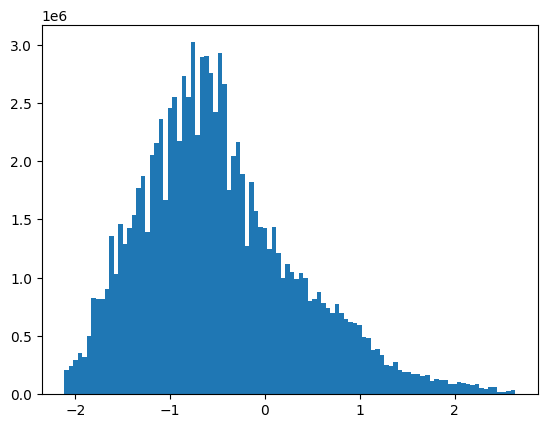

In [10]:
train_loader, valid_loader = load_data(train_dir=train_dir, valid_dir=valid_dir, batchsize=batchsize)
X,y = next(iter(train_loader))
plt.hist(X.data.numpy().flatten(),100)

In [11]:
model, trainLoss, validLoss, trainAcc, validAcc = train_model(resnet, train_loader, valid_loader, optimizer, lossfun, schedular, num_epochs)

0 Training batchLoss/batchAcc 3.8129072189331055/0.01953125%
1 Training batchLoss/batchAcc 3.6767210960388184/0.033203125%
2 Training batchLoss/batchAcc 3.600247621536255/0.0625%
3 Training batchLoss/batchAcc 3.4806478023529053/0.056640625%
4 Training batchLoss/batchAcc 3.387077569961548/0.091796875%
5 Training batchLoss/batchAcc 3.289196729660034/0.14453125%
6 Training batchLoss/batchAcc 3.12772274017334/0.240234375%
7 Training batchLoss/batchAcc 3.026749610900879/0.330078125%
8 Training batchLoss/batchAcc 2.9345834255218506/0.375%
9 Training batchLoss/batchAcc 2.841718912124634/0.447265625%
10 Training batchLoss/batchAcc 2.7282605171203613/0.513671875%
11 Training batchLoss/batchAcc 2.6185338497161865/0.58203125%
12 Training batchLoss/batchAcc 2.553910732269287/0.587890625%
13 Training batchLoss/batchAcc 2.4353792667388916/0.69140625%
14 Training batchLoss/batchAcc 2.3736279010772705/0.703125%
15 Training batchLoss/batchAcc 2.312757730484009/0.72265625%
16 Training batchLoss/batchAcc

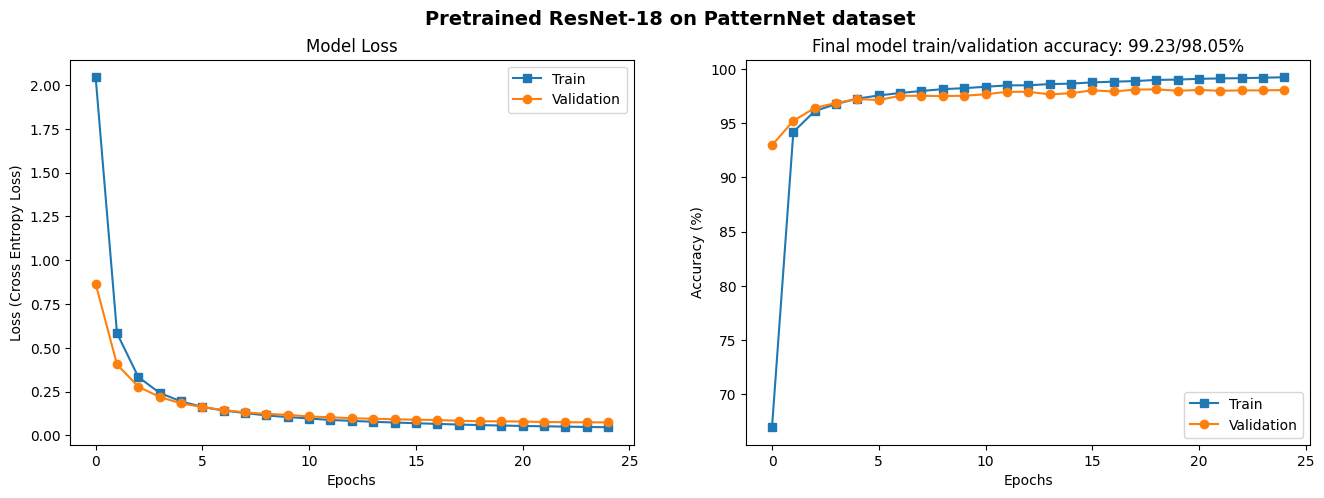

In [12]:
plot_fig(trainLoss, validLoss, trainAcc, validAcc)

In [16]:
from sklearn.metrics import confusion_matrix, precision_score, recall_score

def evaluate_model(model, test_loader, lossfun):
    model.eval()
    test_loss = 0.0
    test_accuracy = 0.0
    test_batches = 0
    all_predictions = []
    all_targets = []

    with torch.no_grad():
        for X_test, y_test in test_loader:
            X_test, y_test = X_test.to(device), y_test.to(device)
            
            # Forward pass
            pred_test = model(X_test)
            loss_test = lossfun(pred_test, y_test)
            test_loss += loss_test.item()

            # Calculate accuracy
            _, predicted = torch.max(pred_test, 1)
            test_accuracy += (predicted == y_test).sum().item()
            test_batches += 1

            all_predictions.extend(predicted.cpu().numpy())
            all_targets.extend(y_test.cpu().numpy())

    avg_test_loss = test_loss / test_batches
    avg_test_accuracy = (test_accuracy / len(test_loader.dataset)) * 100.0

    print(f"Test Set: Average Loss: {avg_test_loss:.4f}, Accuracy: {avg_test_accuracy:.2f}%")
    
    # Calculate confusion matrix, precision, and recall
    conf_matrix = confusion_matrix(all_targets, all_predictions)
    precision = precision_score(all_targets, all_predictions, average='macro')
    recall = recall_score(all_targets, all_predictions, average='macro')
    
    print("Confusion Matrix:")
    print(conf_matrix)
    print(f"Precision: {precision:.4f}, Recall: {recall:.4f}")
    
    return avg_test_loss, avg_test_accuracy, conf_matrix, precision, recall


In [26]:
test_dir = os.path.join('PatternNet','images_test')
transform = T.Compose([T.ToTensor(),
                    T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
                    ])

testset = torchvision.datasets.ImageFolder(root=test_dir, transform=transform)

test_loader = DataLoader(testset, batch_size=batchsize, shuffle=True, drop_last=True)

In [73]:
test_loss, test_accuracy, conf_matrix, precision, recall = evaluate_model(model, test_loader, lossfun)


Test Set: Average Loss: 0.0807, Accuracy: 90.87%
Confusion Matrix:
[[143   0   0 ...   0   0   0]
 [  0 144   1 ...   0   0   0]
 [  1   0 145 ...   1   1   0]
 ...
 [  0   0   2 ... 145   0   0]
 [  0   0   1 ...   0 144   0]
 [  0   0   1 ...   1   0 146]]
Precision: 0.9817, Recall: 0.9812


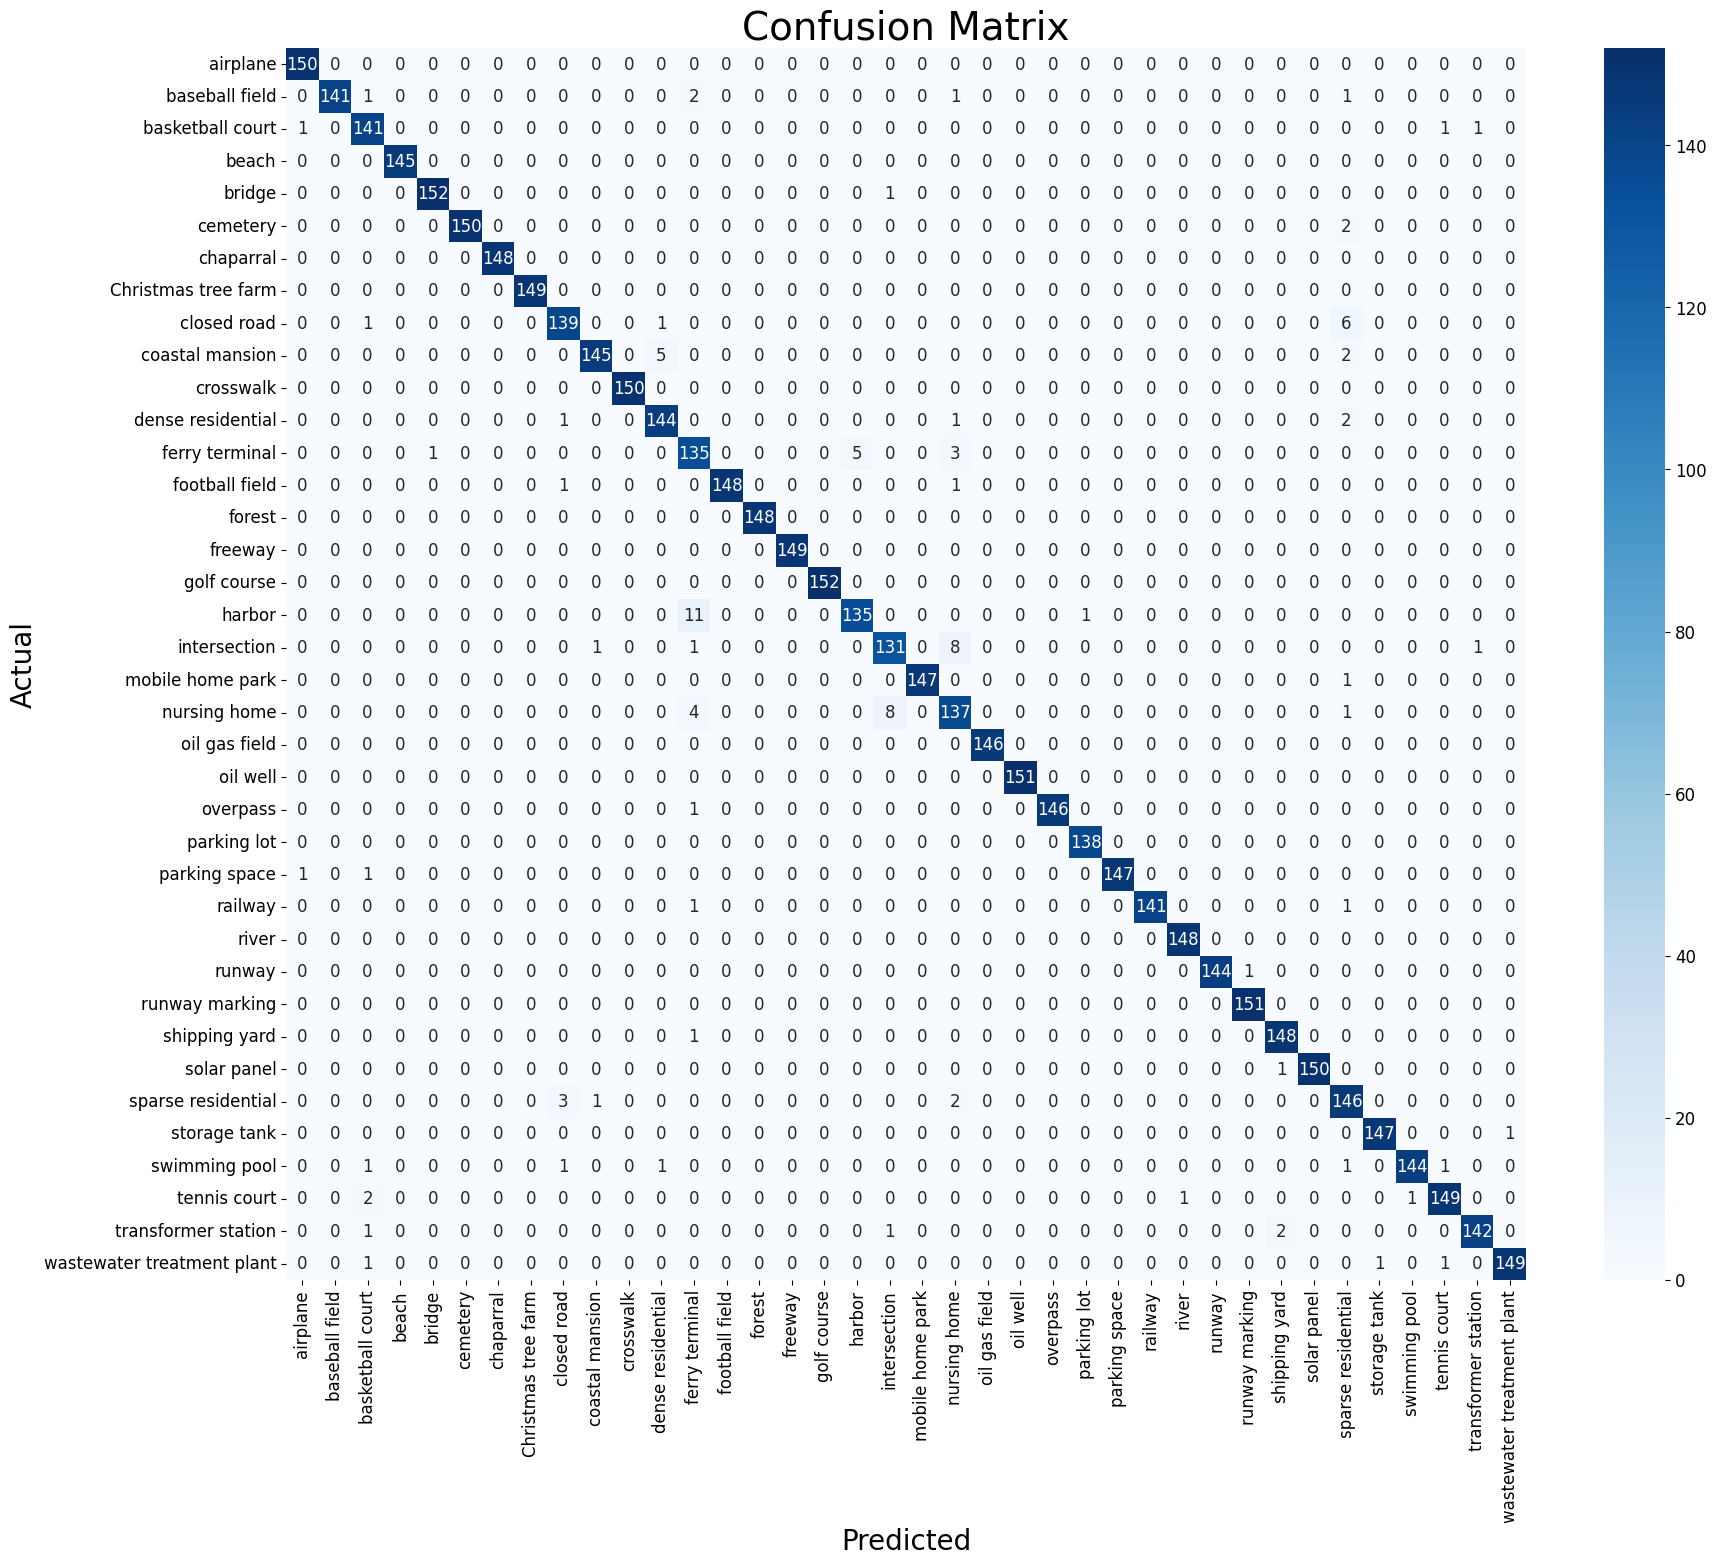

In [59]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_confusion_matrix(conf_matrix, classes):
    plt.figure(figsize=(20, 16))
    plt.rcParams.update({'font.size': 12})
    sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=classes, yticklabels=classes)
    plt.title("Confusion Matrix", fontsize=28)
    plt.xlabel("Predicted", fontsize=20)
    plt.ylabel("Actual", fontsize=20)
    plt.show()

# Assuming you have a list of class names (replace classes_list with your list)
classes_list = [
    'airplane', 'baseball field', 'basketball court', 'beach', 'bridge', 'cemetery',
    'chaparral', 'Christmas tree farm', 'closed road', 'coastal mansion', 'crosswalk',
    'dense residential', 'ferry terminal', 'football field', 'forest', 'freeway',
    'golf course', 'harbor', 'intersection', 'mobile home park', 'nursing home',
    'oil gas field', 'oil well', 'overpass', 'parking lot', 'parking space', 'railway',
    'river', 'runway', 'runway marking', 'shipping yard', 'solar panel', 'sparse residential',
    'storage tank', 'swimming pool', 'tennis court', 'transformer station', 'wastewater treatment plant'
]

# Call the function to plot the confusion matrix
plot_confusion_matrix(conf_matrix, classes_list)

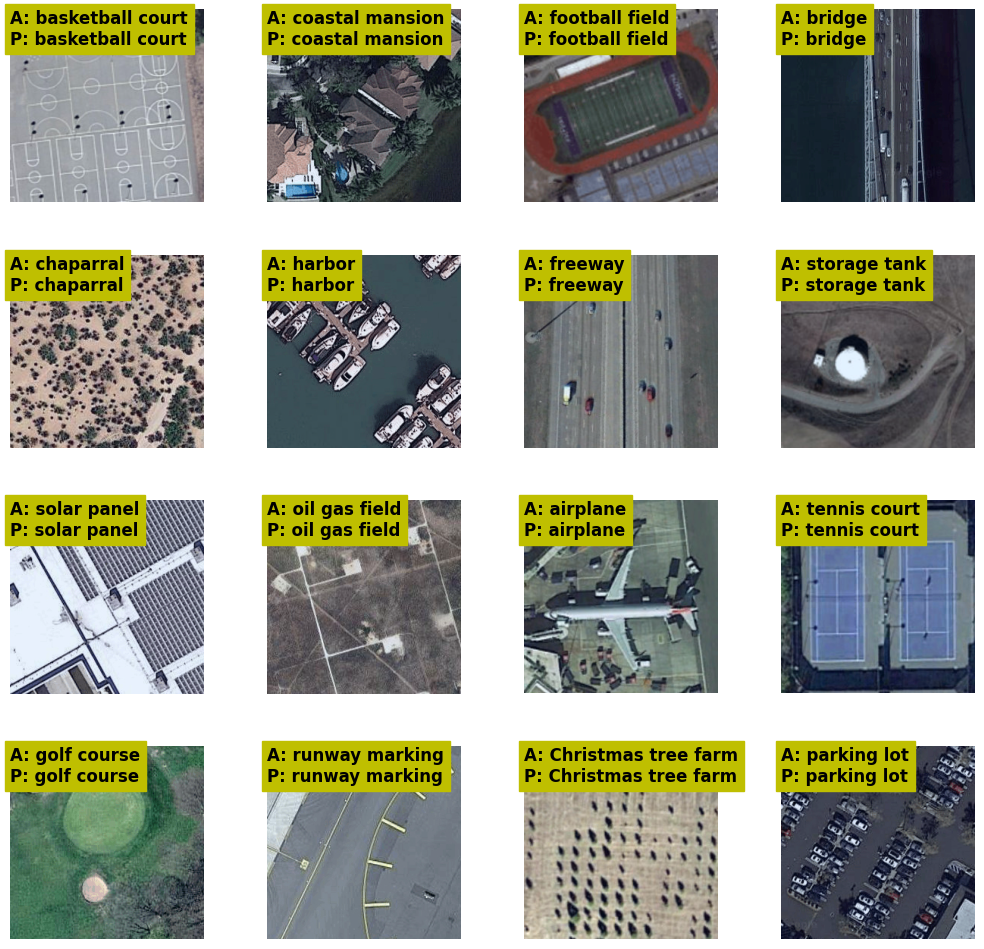

In [57]:
import numpy as np
import matplotlib.pyplot as plt

# Assuming you have predictions in a tensor 'predictions'

X_test, y_test = next(iter(test_loader))
predictions = model(X_test.to(device))

fig, axs = plt.subplots(4, 4, figsize=(10, 10))

for i, ax in enumerate(axs.flatten()):
    # Extract the image, transpose it back to 256x256x3
    pic = X_test[i].cpu().numpy().transpose((1, 2, 0))
    pic = pic - np.min(pic)
    pic = pic / np.max(pic)

    actual_label = classes_list[y_test[i].item()]  # Assuming classes_list contains class names
    predicted_label = classes_list[predictions[i].argmax().item()]  # Adjust this line based on prediction tensor

    ax.imshow(pic)
    ax.text(0, 0, f'A: {actual_label}\nP: {predicted_label}', ha='left', va='top',
            fontweight='bold', color='k', backgroundcolor='y')
    ax.axis('off')

plt.tight_layout()
plt.show()

512
[ 42 162 244 317 322 387 398 402 417 460]


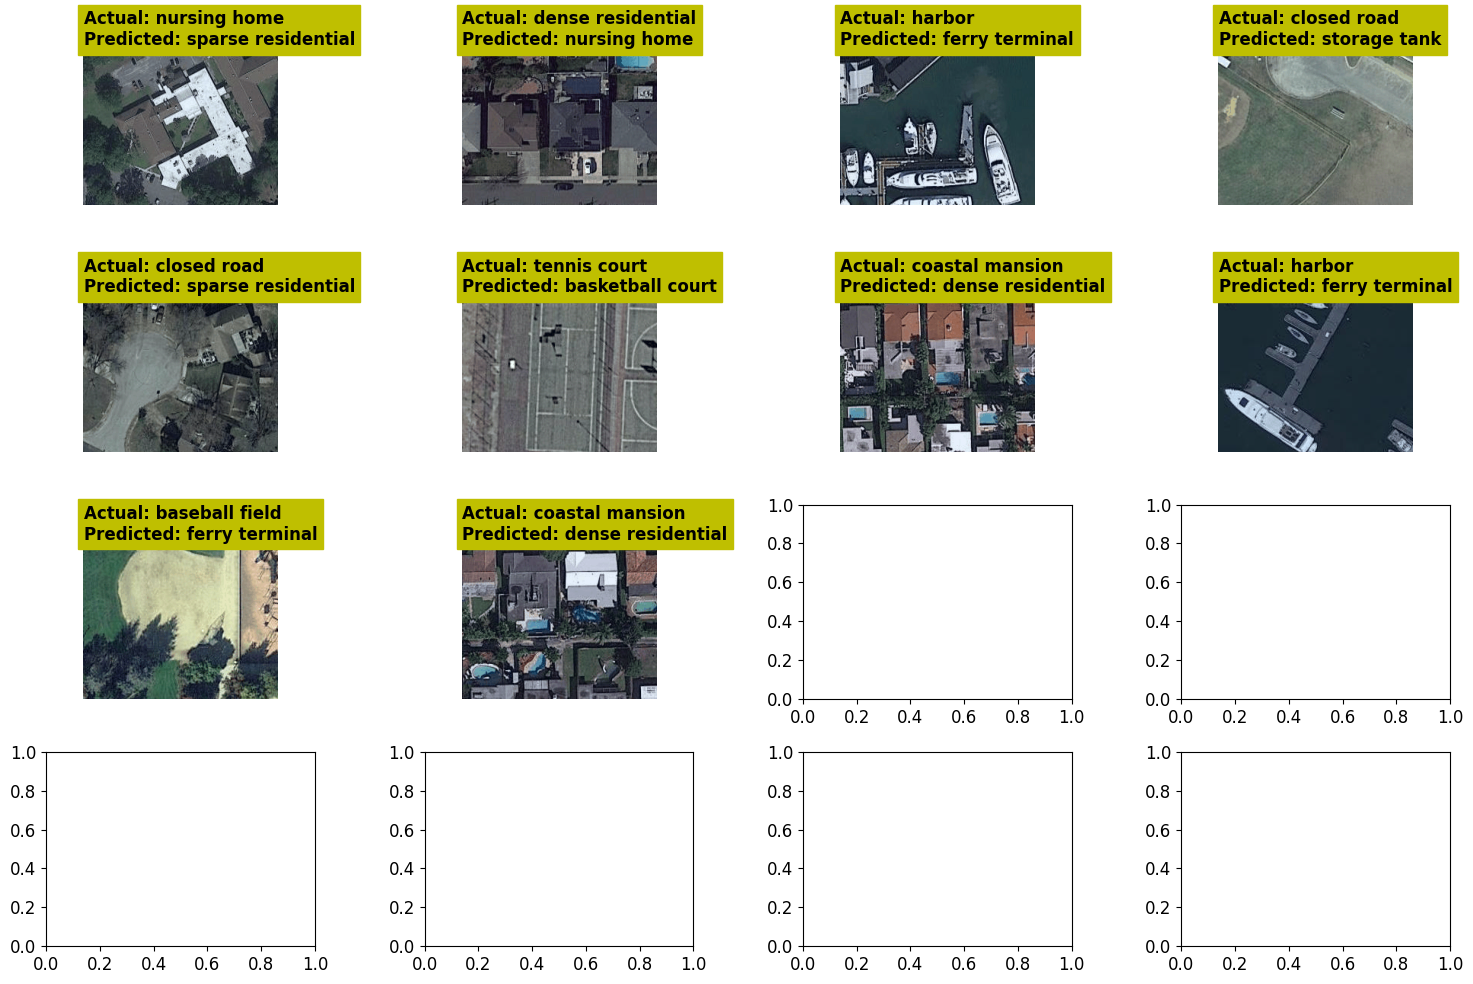

In [93]:
import numpy as np
import matplotlib.pyplot as plt

# Assuming you have predictions in a tensor 'predictions'

X_test, y_test = next(iter(test_loader))
predictions = model(X_test.to(device))

print(len(predictions))

false_preds_indices = np.where(predictions.argmax(1).cpu() != y_test)[0]
print(false_preds_indices)

fig, axs = plt.subplots(4, 4, figsize=(15, 10))

for i, ax in enumerate(axs.flatten()):
    if i < len(false_preds_indices):
        idx = false_preds_indices[i]

        # Extract the image, transpose it back to 256x256x3
        pic = X_test[idx].cpu().numpy().transpose((1, 2, 0))
        pic = pic - np.min(pic)
        pic = pic / np.max(pic)

        actual_label = classes_list[y_test[idx].item()]  # Assuming classes_list contains class names
        predicted_label = classes_list[predictions[idx].argmax().item()]  # Adjust this line based on prediction tensor

        ax.imshow(pic)
        ax.text(0, 0, f'Actual: {actual_label}\nPredicted: {predicted_label}', ha='left', va='top',
                fontweight='bold', color='k', backgroundcolor='y')
        ax.axis('off')

plt.tight_layout()
plt.show()